In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from model.data import get_patient_records, load_pic

In [2]:
ignore_variables = {
    'PATIENTS': ['ROW_ID', 'EXPIRE_FLAG', 'DOD', 'SUBJECT_ID'],
    'ADMISSIONS': ['ROW_ID', 'HADM_ID', 'SUBJECT_ID'],
    'ICUSTAYS': ['ROW_ID', 'HADM_ID', 'ICUSTAY_ID', 'SUBJECT_ID'],
    'SURGERY_INFO': ['ROW_ID', 'HADM_ID', 'SUBJECT_ID', 'VISIT_ID', 'OPER_ID'],
    'DIAGNOSES_ICD': ['ROW_ID', 'HADM_ID', 'SUBJECT_ID'],
    'SURGERY_VITAL_SIGNS': ['ROW_ID', 'HADM_ID', 'SUBJECT_ID', 'VISIT_ID', 'OPER_ID', 'ITEM_NO'],
    'EMR_SYMPTOMS': ['ROW_ID', 'HADM_ID', 'SUBJECT_ID', 'EMR_ID', 'SYMPTOM_NAME_CN'],
    'LABEVENTS': ['ROW_ID', 'HADM_ID', 'SUBJECT_ID', 'VALUEUOM', 'CHARTTIME'],
    'MICROBIOLOGYEVENTS': ['ROW_ID', 'HADM_ID', 'SUBJECT_ID', 'AB_ITEMID', 'ORG_ITEMID', 'SPEC_ITEMID'],
    'OR_EXAM_REPORTS': ['ROW_ID', 'HADM_ID', 'SUBJECT_ID', 'REPORTTIME'],
    'CHARTEVENTS': ['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'VALUEUOM', 'STORETIME'],
    'INPUTEVENTS': ['ROW_ID', 'HADM_ID', 'ICUSTAY_ID', 'SUBJECT_ID'],
    'OUTPUTEVENTS': ['ROW_ID', 'HADM_ID', 'ICUSTAY_ID', 'ITEMID', 'SUBJECT_ID'],
    'PRESCRIPTIONS': ['ROW_ID', 'HADM_ID', 'ICUSTAY_ID', 'SUBJECT_ID', 'DOSE_UNIT_RX', 'PROD_STRENGTH', 
                      'DRUG_NAME_GENERIC', 'DOSE_UNIT_RX', 'DRUG_FORM', 'DRUG_NAME'],
    'D_ITEMS': ['ROW_ID', 'ITEMID', 'UNITNAME', 'LINKSTO', 'LABEL_CN', 'CATEGORY'],
    'D_LABITEMS': ['ROW_ID', 'ITEMID', 'LABEL_CN'],
    'D_ICD_DIAGNOSES': ['ROW_ID']
}

In [3]:
es = load_pic()

Prune (0/1934) rows.
Prune (0/1996) rows.
Prune (0/2108) rows.
Prune (0/1838) rows.
Prune (0/3778) rows.
Prune (0/754213) rows.
Prune (0/75981) rows.
Prune (0/1724805) rows.
Prune (0/29547) rows.
Prune (0/39872) rows.
Prune (0/450989) rows.
Prune (253/2837) rows.
Prune (0/7849) rows.
Prune (0/171332) rows.
Prune (0/479) rows.
Prune (0/832) rows.
Prune (0/25379) rows.


In [5]:
subject_id = 3779

surgery_df = get_patient_records(es, "SURGERY_INFO", subject_id)
surgery_df

surgery_end = surgery_df["SURGERY_END_TIME"].iloc[0]
print(surgery_end)

2114-02-14 16:00:00


In [6]:
prescription_df = get_patient_records(es, "PRESCRIPTIONS", subject_id)
prescription_df

,STARTDATE,ENDDATE,DRUG_NAME,DRUG_NAME_EN,PROD_STRENGTH,DRUG_NAME_GENERIC,DOSE_VAL_RX,DOSE_UNIT_RX,DRUG_FORM
1120542,2114-02-06 09:28:27,2114-02-14 09:28:08,10％葡萄糖注射液,10% Glucose Injection,250ml(Bag),NaN,100.00,ml,injection
1120543,2114-02-06 09:28:27,2114-02-14 09:28:08,胰岛素注射液,Insulin Injection,10ml:400iu,NaN,2.50,iu,injection
1120544,2114-02-06 09:28:27,2114-02-14 09:28:08,10％氯化钾注射液,10% Potassium Chloride Injection,10ml(Bottle),NaN,3.00,ml,injection
1120545,2114-02-06 09:28:54,2114-02-14 09:28:05,(4:1)葡萄糖氯化钠注射液,(4:1)Glucose and Sodium Chloride Injection,50ml(Bag),NaN,50.00,ml,injection
1120546,2114-02-06 09:28:54,2114-02-14 09:28:05,注射用复合辅酶,Coenzyme Complex for Injection,100u+0.1mg,NaN,50.00,u,injection
...,...,...,...,...,...,...,...,...,...
1206925,2114-02-28 10:58:57,NaT,螺内酯片,Spironolactone Tablets,20mg*100,NaN,5.00,mg,tablet/capsule
1206926,2114-02-28 10:59:07,NaT,氢氯噻嗪片,Hydrochlorothiazide Tablets,25mg*100,NaN,6.25,mg,tablet/capsule
1206927,2114-02-28 10:59:18,NaT,布洛芬混悬液,Ibuprofen Suspension,30ml:0.6g,Motrin,5.00,ml,water aqua
1206928,2114-02-28 10:59:51,NaT,葡萄糖酸锌颗粒,Zinc Gluconate Granules,5g:35mg*16,NaN,35.00,mg,powder


In [7]:
prescription_df = prescription_df[prescription_df["STARTDATE"] < surgery_end]
prescription_df

,STARTDATE,ENDDATE,DRUG_NAME,DRUG_NAME_EN,PROD_STRENGTH,DRUG_NAME_GENERIC,DOSE_VAL_RX,DOSE_UNIT_RX,DRUG_FORM
1120542,2114-02-06 09:28:27,2114-02-14 09:28:08,10％葡萄糖注射液,10% Glucose Injection,250ml(Bag),NaN,100.0,ml,injection
1120543,2114-02-06 09:28:27,2114-02-14 09:28:08,胰岛素注射液,Insulin Injection,10ml:400iu,NaN,2.5,iu,injection
1120544,2114-02-06 09:28:27,2114-02-14 09:28:08,10％氯化钾注射液,10% Potassium Chloride Injection,10ml(Bottle),NaN,3.0,ml,injection
1120545,2114-02-06 09:28:54,2114-02-14 09:28:05,(4:1)葡萄糖氯化钠注射液,(4:1)Glucose and Sodium Chloride Injection,50ml(Bag),NaN,50.0,ml,injection
1120546,2114-02-06 09:28:54,2114-02-14 09:28:05,注射用复合辅酶,Coenzyme Complex for Injection,100u+0.1mg,NaN,50.0,u,injection
1120547,2114-02-06 09:28:54,2114-02-14 09:28:05,0.9％氯化钠注射液,0.9% Sodium Chloride Injection,10ml(Bottle),NaN,5.0,ml,injection
1120548,2114-02-06 09:29:12,2114-02-08 09:06:23,(4:1)葡萄糖氯化钠注射液,(4:1)Glucose and Sodium Chloride Injection,50ml(Bag),NaN,50.0,ml,injection
1120549,2114-02-06 09:29:12,2114-02-08 09:06:23,注射用磷酸肌酸钠,Creatine phosphate sodium for injection,0.5g,NaN,0.5,g,injection
1120550,2114-02-06 09:29:12,2114-02-08 09:06:23,灭菌注射用水,Sterile Water Injection,5ml*50,NaN,5.0,ml,injection
1120551,2114-02-06 09:29:32,2114-02-14 12:17:07,0.9％氯化钠注射液,0.9% Sodium Chloride Injection,10ml(Bottle),NaN,2.0,ml,injection


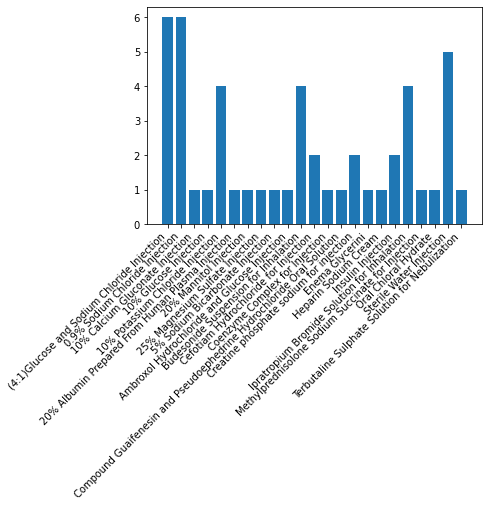

In [8]:
import matplotlib.pyplot as plt
import numpy as np

values, counts = np.unique(prescription_df["DRUG_NAME_EN"], return_counts=True)

x = np.arange(len(values))
y = counts

plt.bar(x, y)
plt.xticks(ticks=x, labels=values, rotation=45, ha='right')
plt.show()

In [9]:
es["SURGERY_INFO"].df

,UNI_OPER_ID,ROW_ID,SUBJECT_ID,HADM_ID,VISIT_ID,OPER_ID,ANES_START_TIME,ANES_END_TIME,SURGERY_BEGIN_TIME,SURGERY_END_TIME,...,Surgical time (minutes),CPB time (minutes),Aortic cross-clamping time (times),complication,lung complication,cardiac complication,arrhythmia complication,infectious complication,other complication,Age
604873,604873,1573,9280,109451,1,1,2067-01-06 11:02:00,2067-01-06 13:45:00,2067-01-06 11:35:00,2067-01-06 13:35:00,...,120,64.0,33.0,0,0,0,0,0,0,4
614281,614281,2700,9413,109598,1,1,2067-01-14 14:43:00,2067-01-14 17:48:00,2067-01-14 15:26:00,2067-01-14 17:41:00,...,132,69.0,40.0,0,0,0,0,0,0,20
609417,609417,670,9341,109522,1,1,2067-02-03 11:40:00,2067-02-03 16:11:00,2067-02-03 12:27:00,2067-02-03 16:10:00,...,220,147.0,120.0,0,0,0,0,0,0,48
399113,399113,7124,5886,106236,1,1,2067-04-14 08:55:00,2067-04-14 12:20:00,2067-04-14 10:05:00,2067-04-14 12:10:00,...,124,71.0,44.0,0,0,0,0,0,0,2
429001,429001,2096,3718,106703,1,1,2067-05-10 18:30:00,2067-05-10 21:08:00,2067-05-10 19:11:00,2067-05-10 20:55:00,...,102,49.0,29.0,0,0,0,0,0,0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
812617,812617,704,12274,112697,1,1,2118-06-14 10:26:00,2118-06-14 11:59:00,2118-06-14 11:08:00,2118-06-14 11:56:00,...,48,NaN,NaN,0,0,0,0,0,0,76
788113,788113,5833,11431,112314,2,1,2118-08-09 15:30:00,2118-08-09 19:50:00,2118-08-09 16:20:00,2118-08-09 19:45:00,...,203,96.0,56.0,0,0,0,0,0,0,19
894993,894993,5446,13341,113984,2,1,2118-08-31 12:56:00,2118-08-31 13:25:00,2118-08-31 13:07:00,2118-08-31 13:23:00,...,101,40.0,24.0,0,0,0,0,0,0,21
827657,827657,6367,12488,112932,1,1,2118-09-08 08:48:00,2118-09-08 10:30:00,2118-09-08 09:30:00,2118-09-08 10:27:00,...,95,NaN,NaN,0,0,0,0,0,0,0


In [11]:
import sys
import featuretools as ft

prescription_df = es["PRESCRIPTIONS"].df
values, counts = np.unique(prescription_df["DRUG_NAME_EN"], return_counts=True)

def exists(column, values=None):
    assert values is not None
    return [v in column.values for v in values]

target_entity = 'SURGERY_INFO'
label_times = es['SURGERY_INFO'].df[['UNI_OPER_ID', 'SURGERY_END_TIME']]
label_times.columns = ['instance_id', 'time']

Medications = ft.primitives.make_agg_primitive(function=exists,
                                 input_types=[ft.variable_types.Discrete],
                                 return_type=ft.variable_types.Boolean,
                                 number_output_features=len(values))
    
med_feature_matrix, med_features_list = ft.dfs(entityset=es,
                                       target_entity=target_entity,
                                       agg_primitives=[Medications(values=values)],
                                       trans_primitives=[],
                                       allowed_paths=[['SURGERY_INFO', 'ADMISSIONS'],  
                                                      ['SURGERY_INFO', 'ADMISSIONS', 'PRESCRIPTIONS']],
                                       ignore_variables=ignore_variables,
                                       cutoff_time=label_times,
                                       max_depth=2,
                                       verbose=True)

med_feature_matrix = med_feature_matrix.fillna(0)

Built 319 features
Elapsed: 04:06 | Progress: 100%|██████████


In [21]:
print(med_features_list[100])

descriptions = ["Patient has taken " + s for s in values]

primitive_templates = {'exists': descriptions} 

ft.describe_feature(med_features_list[100], primitive_templates=primitive_templates)

<Feature: ADMISSIONS.EXISTS(PRESCRIPTIONS.DRUG_NAME_EN)[73]>


'Patient has taken Clarithromycin Granule for Oral Suspension of all instances of "PRESCRIPTIONS" for each "HADM_ID" in "ADMISSIONS" for the instance of "ADMISSIONS" associated with this instance of "SURGERY_INFO".'

In [22]:
drug_feature_matrix = med_feature_matrix.copy()

for column in med_feature_matrix:
    if not "ADMISSIONS.EXISTS(PRESCRIPTIONS.DRUG_NAME_EN)" in column:
        drug_feature_matrix.drop(column, inplace=True, axis="columns")
        
drug_feature_matrix

,ADMISSIONS.EXISTS(PRESCRIPTIONS.DRUG_NAME_EN)[0],ADMISSIONS.EXISTS(PRESCRIPTIONS.DRUG_NAME_EN)[1],ADMISSIONS.EXISTS(PRESCRIPTIONS.DRUG_NAME_EN)[2],ADMISSIONS.EXISTS(PRESCRIPTIONS.DRUG_NAME_EN)[3],ADMISSIONS.EXISTS(PRESCRIPTIONS.DRUG_NAME_EN)[4],ADMISSIONS.EXISTS(PRESCRIPTIONS.DRUG_NAME_EN)[5],ADMISSIONS.EXISTS(PRESCRIPTIONS.DRUG_NAME_EN)[6],ADMISSIONS.EXISTS(PRESCRIPTIONS.DRUG_NAME_EN)[7],ADMISSIONS.EXISTS(PRESCRIPTIONS.DRUG_NAME_EN)[8],ADMISSIONS.EXISTS(PRESCRIPTIONS.DRUG_NAME_EN)[9],...,ADMISSIONS.EXISTS(PRESCRIPTIONS.DRUG_NAME_EN)[282],ADMISSIONS.EXISTS(PRESCRIPTIONS.DRUG_NAME_EN)[283],ADMISSIONS.EXISTS(PRESCRIPTIONS.DRUG_NAME_EN)[284],ADMISSIONS.EXISTS(PRESCRIPTIONS.DRUG_NAME_EN)[285],ADMISSIONS.EXISTS(PRESCRIPTIONS.DRUG_NAME_EN)[286],ADMISSIONS.EXISTS(PRESCRIPTIONS.DRUG_NAME_EN)[287],ADMISSIONS.EXISTS(PRESCRIPTIONS.DRUG_NAME_EN)[288],ADMISSIONS.EXISTS(PRESCRIPTIONS.DRUG_NAME_EN)[289],ADMISSIONS.EXISTS(PRESCRIPTIONS.DRUG_NAME_EN)[290],ADMISSIONS.EXISTS(PRESCRIPTIONS.DRUG_NAME_EN)[291]
UNI_OPER_ID,,,,,,,,,,,,,,,,,,,,,
604873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
614281,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
609417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
399113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
429001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
812617,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
788113,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
894993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
prescription_counts = drug_feature_matrix.sum(axis="rows")
prescription_counts

ADMISSIONS.EXISTS(PRESCRIPTIONS.DRUG_NAME_EN)[0]        4.0
ADMISSIONS.EXISTS(PRESCRIPTIONS.DRUG_NAME_EN)[1]        1.0
ADMISSIONS.EXISTS(PRESCRIPTIONS.DRUG_NAME_EN)[2]      871.0
ADMISSIONS.EXISTS(PRESCRIPTIONS.DRUG_NAME_EN)[3]      489.0
ADMISSIONS.EXISTS(PRESCRIPTIONS.DRUG_NAME_EN)[4]        2.0
                                                      ...  
ADMISSIONS.EXISTS(PRESCRIPTIONS.DRUG_NAME_EN)[287]      0.0
ADMISSIONS.EXISTS(PRESCRIPTIONS.DRUG_NAME_EN)[288]      1.0
ADMISSIONS.EXISTS(PRESCRIPTIONS.DRUG_NAME_EN)[289]     16.0
ADMISSIONS.EXISTS(PRESCRIPTIONS.DRUG_NAME_EN)[290]     11.0
ADMISSIONS.EXISTS(PRESCRIPTIONS.DRUG_NAME_EN)[291]      0.0
Length: 292, dtype: float64

In [40]:
names = []
counts = []
for med in prescription_counts.index:
    # extract the number in the brackets of the feature name, and get the corresponding med name
    names.append(values[int(med[med.find("[")+1:med.find("]")])])  
    counts.append(prescription_counts[med])
    
    
sort_order = np.argsort(counts)[::-1]

names = np.array(names)[sort_order]
counts = np.array(counts)[sort_order]

total = drug_feature_matrix.shape[0]

1838


Most common medications: 
        (4:1)Glucose and Sodium Chloride Injection --- 47%
                           Sterile Water Injection --- 47%
                                   Enema Glycerini --- 46%
                  10% Potassium Chloride Injection --- 42%
                           Cefradine for Injection --- 40%
                   5% Sodium Bicarbonate Injection --- 37%
  20% Albumin Prepared From Human Plasma Injection --- 37%
                   25% Magnesium Sulfate Injection --- 37%
                   10% Calcium Gluconate Injection --- 37%
 Methylprednisolone Sodium Succinate for Injection --- 37%
                            20% Mannitol Injection --- 36%
           Creatine phosphate sodium for injection --- 36%
                    0.9% Sodium Chloride Injection --- 26%
                  Chloral hydrate powder for enema --- 17%
                            Spironolactone Tablets --- 12%
                       Hydrochlorothiazide Tablets --- 12%
                              

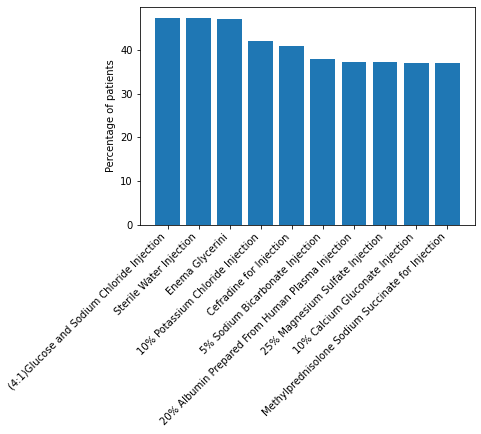

In [58]:
N = 10

print("Most common medications: ")
for name, count in zip(names[:20], counts[:20]):
    print("%50s --- %2i%%" % (name, count*100//total))

x = np.arange(N)
y = counts[:N] / total * 100

plt.bar(x, y)
plt.xticks(ticks=x, labels=names[:N], rotation=45, ha='right')
plt.ylabel("Percentage of patients")
plt.show()